In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# a) Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

import os

In [5]:
# ==========================================================
# Step 1: Load the Pre-trained CNN Model (VGG16 without top(own custom classification layers later.))
# ==========================================================
base_model = VGG16(weights='/content/drive/MyDrive/Object Detection(Ass6)/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                   include_top=False,
                   input_shape=(224, 224, 3))

print("✅ Pre-trained VGG16 model loaded successfully.")

✅ Pre-trained VGG16 model loaded successfully.


In [6]:
# ==========================================================
# Step 2: Freeze lower convolutional layers  ( their weights will not be updated during the first training stage)
# ==========================================================
for layer in base_model.layers:
    layer.trainable = False

print("✅ Base layers frozen.")

# ==========================================================
# Step 3: Add custom classifier (fully connected layers)(the extra layers we add on top of a pre-trained CNN model to perform classification for our specific task)
# ==========================================================
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(102, activation='softmax')
# ])
model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])


✅ Base layers frozen.


In [7]:
# ==========================================================
# Step 4: Compile the model (model how to learn)
# ==========================================================
model.compile(optimizer=Adam(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# ==========================================================
# Step 5: Prepare the dataset (images in subfolders)
# ==========================================================
data_dir = "/content/drive/MyDrive/object"  # your dataset folder

# train_datagen → Rules for preprocessing images
# train_generator → Loads & feeds training images
# val_generator → Loads & feeds validation images

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("✅ Dataset loaded successfully.")


print("Number of classes:", train_generator.num_classes)


Found 260 images belonging to 4 classes.
Found 63 images belonging to 4 classes.
✅ Dataset loaded successfully.
Number of classes: 4


In [9]:
# ==========================================================
# Step 6: Train the classifier layers  (Training only the classifier avoids destroying the base model’s features)
# ==========================================================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 223s 24s/step - accuracy: 0.2933 - loss: 330.5303 - val_accuracy: 0.8571 - val_loss: 19.2022


In [11]:
# ==========================================================
# Step 7: Fine-tune (unfreeze top layers)
# ==========================================================
# Unfreeze last 4 convolutional layers(We unfreeze the last 4 convolutional layers so the model can fine-tune higher-level feature extractors to the new dataset)
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile with smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("🔄 Fine-tuning top layers...")

# fit() performs the actual training using the training data and updates the model weights.

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1
)

🔄 Fine-tuning top layers...
9/9 ━━━━━━━━━━━━━━━━━━━━ 216s 26s/step - accuracy: 0.8471 - loss: 13.5826 - val_accuracy: 0.8571 - val_loss: 6.2822


In [ ]:
# ==========================================================
# Step 8: Evaluate and Save the model
# ==========================================================
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Final Validation Accuracy: {acc*100:.2f}%")

model.save("vgg16_transfer_learning_final.h5")
print("✅ Model saved successfully as vgg16_transfer_learning_final.h5")


2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 20s/step - accuracy: 0.9894 - loss: 0.2928



✅ Final Validation Accuracy: 98.41%
✅ Model saved successfully as vgg16_transfer_learning_final.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


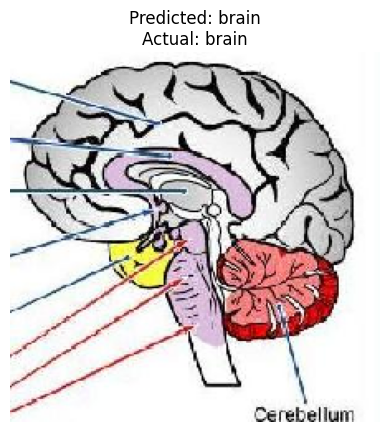

In [ ]:
import matplotlib.pyplot as plt
x_test, y_test = next(val_generator)
import numpy as np
# Make predictions
predicted_value = model.predict(x_test)

# Get label names
labels = list(train_generator.class_indices.keys())

# Show example
n = 22  # choose any image index
plt.imshow(x_test[n])
plt.axis('off')
plt.title(f"Predicted: {labels[np.argmax(predicted_value[n])]}\nActual: {labels[np.argmax(y_test[n])]}")
plt.show()

✅ 1. Why do we use a pre-trained VGG16 model?

We use VGG16 pre-trained on ImageNet to leverage its learned visual features like edges, textures, and shapes, instead of training from scratch. This saves time and improves performance on small datasets.

✅ 2. Why include_top=False?

We remove the original fully connected (top) layers because they were trained to classify 1000 ImageNet classes; we need to add new layers for our dataset categories.

✅ 3. Why do we freeze layers first?

We freeze layers so the pre-trained convolution filters don't get destroyed by random updates and only the new classifier learns initially, ensuring stable feature transfer.

✅ 38. Why use softmax activation in last layer?

Softmax outputs probability for each class; the class with highest probability is predicted.

✅ 39. Why use Categorical Cross Entropy?

It compares predicted probability distribution and true one-hot labels, used for multi-class classification.